# Give Me Some Credit

#### 🎯 Objective

The goal of this project is to build a robust and interpretable machine learning pipeline that predicts the **probability of default (PD)** for credit clients and estimates the **Expected Credit Loss (ECL)** using simplified assumptions.

This approach is based on the **IFRS 9 framework**, which defines ECL as:

$$
\text{ECL} = \text{PD} \times \text{LGD} \times \text{EAD}
$$

Where:
- **PD** — Probability of Default
- **LGD** — Loss Given Default
- **EAD** — Exposure at Default

#### 🧾 Dataset

We use the publicly available [**"Give Me Some Credit"** dataset](https://www.kaggle.com/c/GiveMeSomeCredit) from Kaggle:
- Contains financial and behavioral data about 150,000 loan applicants.
- Binary target: whether a client defaulted within the next 2 years (`SeriousDlqin2yrs`).
- No information on actual loan amount or recovery — hence **LGD and EAD must be estimated**.

#### 🛠️ Challenges

- Target variable is **imbalanced** (~6.7% defaults).
- Features contain **missing values** and **extreme outliers**.
- Dataset lacks direct inputs for ECL modeling (no LGD/EAD), requiring assumptions and engineering.


In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import shap

In [3]:
data = pd.read_csv('D:\Files\Portfolio Data Science\ECL\give-me-some-credit\data\cs-training.csv', index_col=0)
test_data = pd.read_csv('D:\Files\Portfolio Data Science\ECL\give-me-some-credit\data\cs-test.csv', index_col=0)

In [4]:
# dictionary for renaming columns
rename_dict = {
    'SeriousDlqin2yrs': 'target',
    'RevolvingUtilizationOfUnsecuredLines': 'revolving_utilization',
    'NumberOfTime30-59DaysPastDueNotWorse': 'past_due_30_59',
    'DebtRatio': 'debt_ratio',
    'MonthlyIncome': 'monthly_income',
    'NumberOfOpenCreditLinesAndLoans': 'open_credit_lines',
    'NumberOfTimes90DaysLate': 'past_due_90_plus',
    'NumberRealEstateLoansOrLines': 'real_estate_loans',
    'NumberOfTime60-89DaysPastDueNotWorse': 'past_due_60_89',
    'NumberOfDependents': 'dependents'
}

data.rename(columns=rename_dict, inplace=True)
test_data.rename(columns=rename_dict, inplace=True)

display(data.head())
display(test_data.head())

,target,revolving_utilization,age,past_due_30_59,debt_ratio,monthly_income,open_credit_lines,past_due_90_plus,real_estate_loans,past_due_60_89,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


,target,revolving_utilization,age,past_due_30_59,debt_ratio,monthly_income,open_credit_lines,past_due_90_plus,real_estate_loans,past_due_60_89,dependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [5]:
# train and test model before data analysis
X = data.drop('target', axis=1).fillna(0)
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("Train ROC-AUC:", round(roc_auc_score(y_train, y_train_pred_proba), 4))

y_pred_proba = model.predict_proba(X_val)[:, 1]
print("ROC-AUC:", round(roc_auc_score(y_val, y_pred_proba), 4))

Train ROC-AUC: 0.693
ROC-AUC: 0.7089


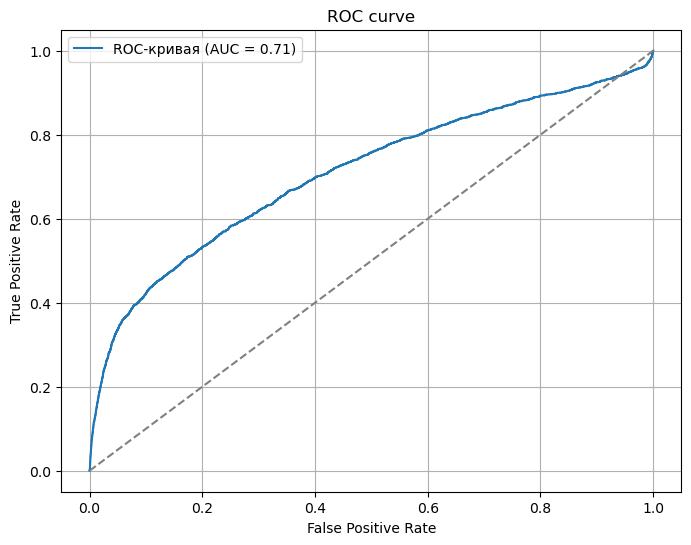

In [6]:
# Building a ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-кривая (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.show()

We trained and tested the model on raw data without preprocessing to check the quality after preprocessing. The result of the ROC metric on training data is 0.69 and on test data 0.71. Let's try to improve the results.

## Exploratory Data Analysis

In [7]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   target                 150000 non-null  int64  
 1   revolving_utilization  150000 non-null  float64
 2   age                    150000 non-null  int64  
 3   past_due_30_59         150000 non-null  int64  
 4   debt_ratio             150000 non-null  float64
 5   monthly_income         120269 non-null  float64
 6   open_credit_lines      150000 non-null  int64  
 7   past_due_90_plus       150000 non-null  int64  
 8   real_estate_loans      150000 non-null  int64  
 9   past_due_60_89         150000 non-null  int64  
 10  dependents             146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


,count,mean,std,min,25%,50%,75%,max
target,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
revolving_utilization,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
past_due_30_59,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
debt_ratio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
monthly_income,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
open_credit_lines,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
past_due_90_plus,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
real_estate_loans,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
past_due_60_89,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


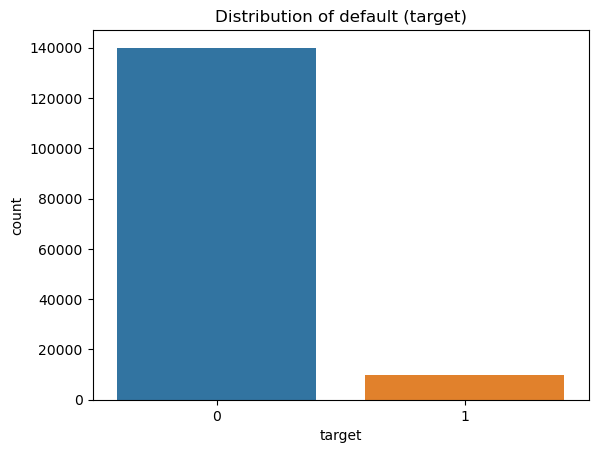

target
0    0.93316
1    0.06684
Name: proportion, dtype: float64


In [8]:
sns.countplot(x='target', data=data)
plt.title('Distribution of default (target)')
plt.show()

print(data['target'].value_counts(normalize=True))

📊 **General Structure:**
- 150,000 rows, 11 features
- Target variable `target` is imbalanced with a slight skew: \~6.7% defaults
- 2 features contain missing values:
    - `monthly_income`: \~20% missing
    - `dependents`: \~2.6% missing
 
⚠️ **Suspicious Values and Outliers:**
- `age`: minimum = 0 — not possible, data error
- `revolving_utilization`: max = 50,708.0 — over 5,000,000% usage rate, anomaly
- `debt_ratio`: max = 329,664.0 — also an anomaly
- `monthly_income`: max = 3,008,750.0 — most likely an outlier
- `past_due_*`: max = 98 — likely a coded value (e.g., "98 or more"), needs verification

🧮 **Distributions:**
- open_credit_lines, real_estate_loans, dependents — reasonable ranges
- past_due_30_59, past_due_60_89, past_due_90_plus — mostly 0s, but extreme values up to 98

**Conclusion:**
- Significant outliers in numeric features — requires handling (e.g., clip, log-transform, or winsorization)
- Missing values should be filled (e.g., with median or a separate category)
- `target` is imbalanced → consider this during modeling (e.g., `class_weight='balanced'` in classifiers)

In [9]:
# Before removing
before = data.shape

# Removing duplicates
data = data.drop_duplicates()

dup_features = [
    'monthly_income',
    'debt_ratio',
    'age',
    'revolving_utilization',
    'open_credit_lines',
    'real_estate_loans',
    'dependents',
    'past_due_30_59',
    'past_due_60_89',
    'past_due_90_plus'
]
data = data.drop_duplicates(subset=dup_features)

# After removing
after = data.shape
print("Duplicates deleted: ", before[0] - after[0])

Duplicates deleted:  646


In [10]:
# Creating new df for Exploratory Data Analysis, original df will be processed in pipeline
data_eda = data.copy()

##### age: there are values <18 - this is an error, we will delete such lines

In [11]:
data_eda = data_eda[data_eda['age'] >= 18]

##### Upper percentile outlier limitation

In [12]:
# Extreme values limit
def cap_outliers(df, column, upper_quantile=0.99):
    cap = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(upper=cap)

for col in ['revolving_utilization', 'debt_ratio', 'monthly_income']:
    cap_outliers(data_eda, col)

<Axes: >

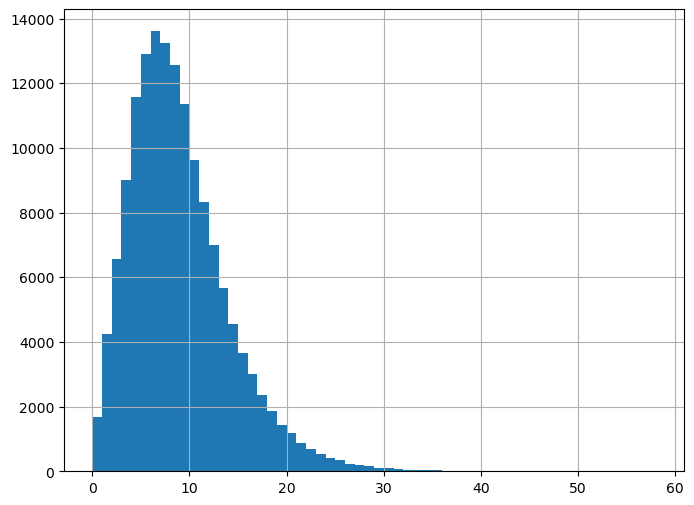

In [13]:
data_eda['open_credit_lines'].hist(bins=58, figsize=(8, 6))

In [14]:
# Removing clients with open_credit_lines > 30
data_eda = data_eda[data_eda['open_credit_lines'] <= 30]

##### Processing past_due_* variables

In [15]:
for col in ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus']:
    print(f"\n{col} value counts:")
    print(data_eda[col].value_counts().sort_index())


past_due_30_59 value counts:
past_due_30_59
0     125144
1      15984
2       4585
3       1748
4        747
5        339
6        139
7         54
8         24
9         12
10         4
11         1
12         2
13         1
96         5
98       210
Name: count, dtype: int64

past_due_60_89 value counts:
past_due_60_89
0     141458
1       5724
2       1117
3        318
4        105
5         34
6         16
7          9
8          1
9          1
11         1
96         5
98       210
Name: count, dtype: int64

past_due_90_plus value counts:
past_due_90_plus
0     140739
1       5221
2       1555
3        667
4        290
5        131
6         79
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       210
Name: count, dtype: int64


In [16]:
# limiting past_due_*
for col in ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus']:
    data_eda[col] = data_eda[col].clip(upper=10)

##### Filling in the data gaps

In [17]:
# Filling in the blanks with the median for monthly_income and 0 for dependents (let's say "no dependents")
data_eda['monthly_income'] = data_eda['monthly_income'].fillna(data_eda['monthly_income'].median())
data_eda['dependents'] = data_eda['dependents'].fillna(0)

##### Post-processing check:

In [18]:
data_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
target,148999.0,0.066853,0.249768,0.0,0.000000,0.000000,0.000000,1.000000
revolving_utilization,148999.0,0.319811,0.351327,0.0,0.030100,0.154100,0.556722,1.093945
age,148999.0,52.296606,14.729591,21.0,41.000000,52.000000,63.000000,109.000000
past_due_30_59,148999.0,0.260559,0.789302,0.0,0.000000,0.000000,0.000000,10.000000
debt_ratio,148999.0,317.967263,908.631411,0.0,0.177322,0.367824,0.876117,4985.480000
monthly_income,148999.0,6159.971738,3917.555564,0.0,3900.000000,5400.000000,7400.000000,25000.000000
open_credit_lines,148999.0,8.417795,4.955698,0.0,5.000000,8.000000,11.000000,30.000000
past_due_90_plus,148999.0,0.104806,0.608729,0.0,0.000000,0.000000,0.000000,10.000000
real_estate_loans,148999.0,1.018027,1.100464,0.0,0.000000,1.000000,2.000000,23.000000
past_due_60_89,148999.0,0.079450,0.501046,0.0,0.000000,0.000000,0.000000,10.000000


✅ 1. Missing values processed
- monthly_income: missing values (≈20% of the sample) were replaced with the median (5400.0), which allowed us to preserve the distribution and avoid bias.
- dependents: missing values were replaced with 0 — it is logical to interpret this as the absence of dependents.

✅ 2. Outliers and anomalies processed
- revolving_utilization: the maximum value is now 1.09, it used to be 50708 — this means that extreme outliers have been removed or limited.
- debt_ratio: the maximum is now 4985, it used to be 329664 — extreme values have also been processed.
- past_due_* variables (30-59, 60-89, 90+):
- maximums are now 10, instead of 98 — assumed code values (e.g. 96, 98) have been replaced with realistic values within the variable logic.

✅ 3. Distributions look adequate
- Most variables have reasonable values:
    - age: from 21 to 109 years old, which corresponds to the real age sample.
    - open_credit_lines: on average ~8, maximum 30 — acceptable.
    - real_estate_loans: on average 1, maximum 23 — acceptable.
- past_due_* variables now reflect the real delinquency rate: average values are low, median = 0.

#### Distribution

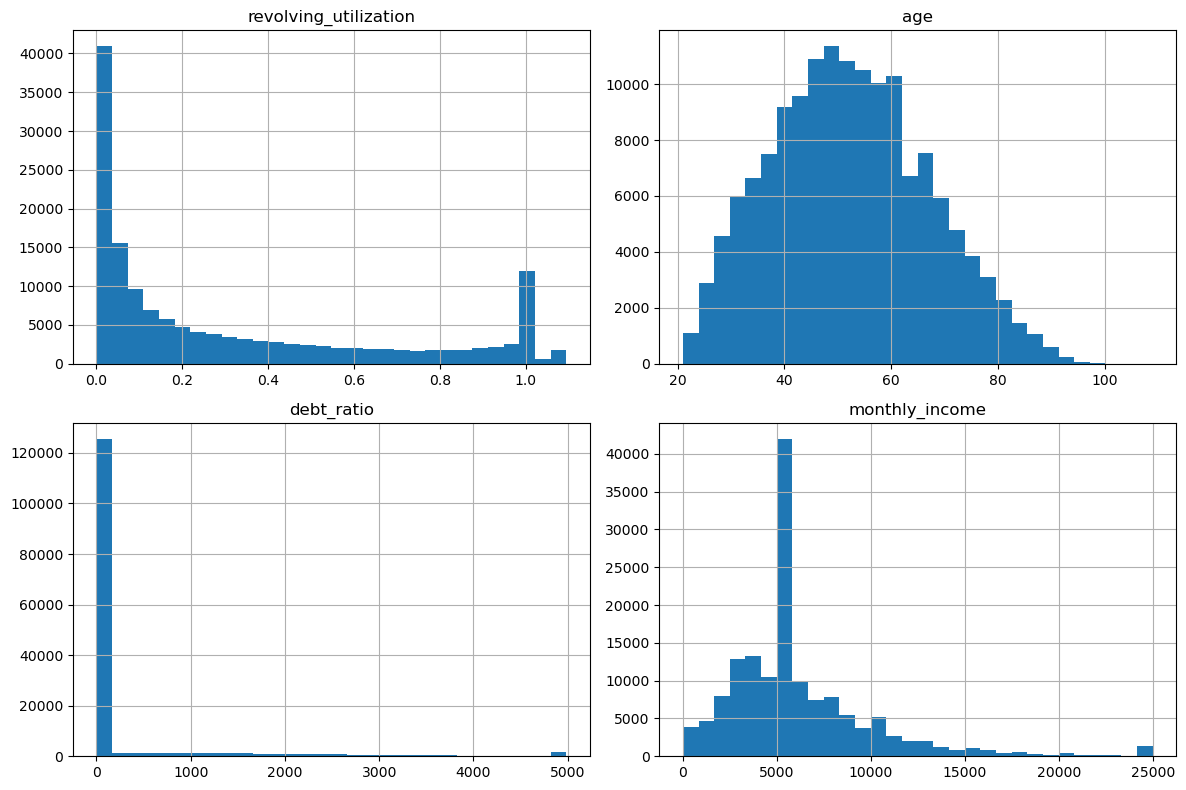

In [19]:
continuous = ['revolving_utilization', 'age', 'debt_ratio', 'monthly_income']
data_eda[continuous].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Key features:
- Distributions became realistic and limited, without anomalies.
- revolving_utilization — skewed to the left, with a peak around 0; reasonable maximum ~1.
- age — symmetrically distributed with a peak at ~50 years.
- debt_ratio — strongly skewed to the right, but outliers removed; the bulk is up to 500.
- monthly_income — peak value ~5000; abnormally high incomes removed.

📌 Conclusion: after cleaning, the features became suitable for modeling and visual analysis.

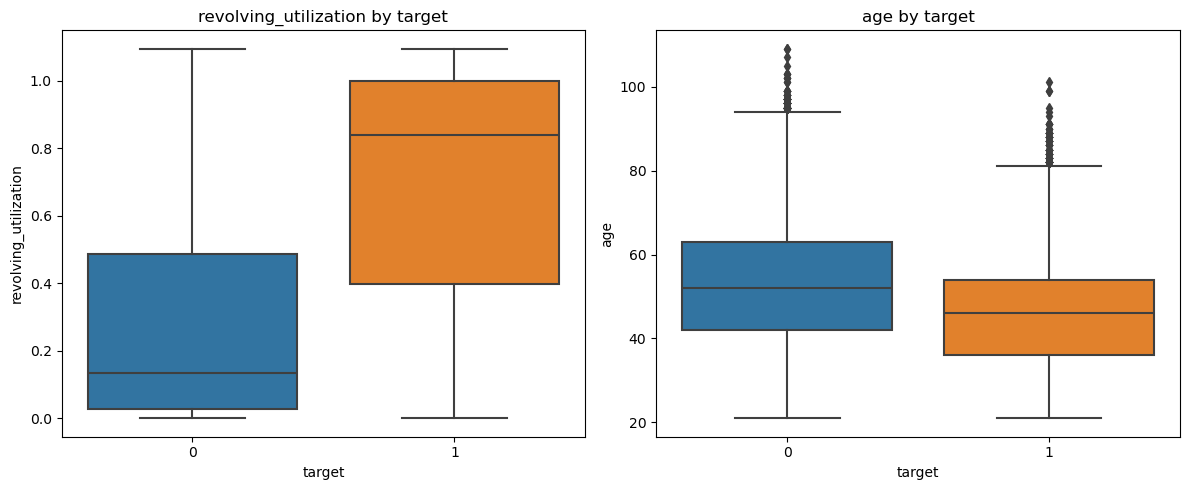

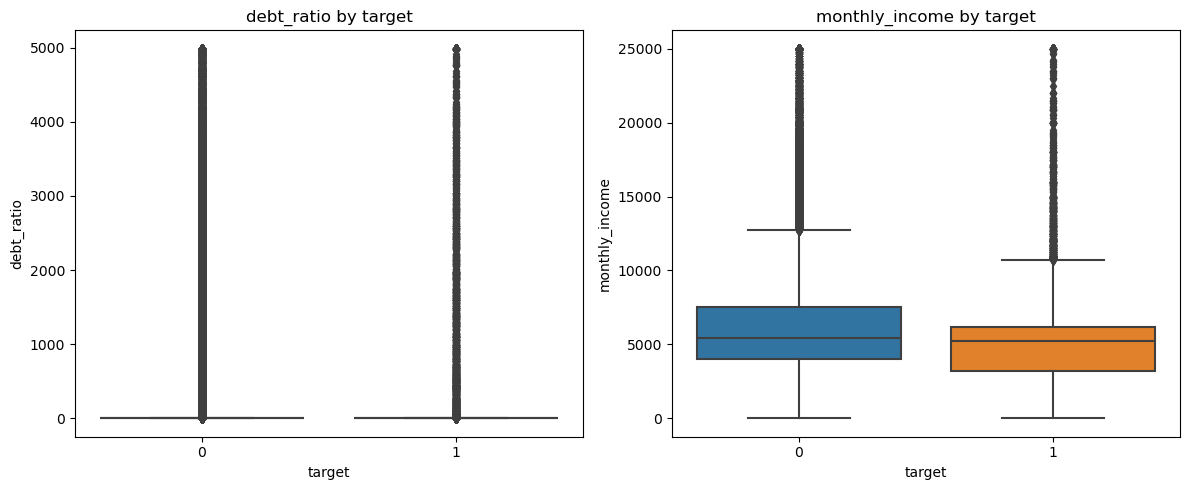

In [20]:
for i in range(0, len(continuous), 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for j in range(2):
        if i + j < len(continuous):
            sns.boxplot(
                x='target',
                y=continuous[i + j],
                data=data_eda,
                ax=axes[j]
            )
            axes[j].set_title(f"{continuous[i + j]} by target")
    plt.tight_layout()
    plt.show()

Observations:
- revolving_utilization: defaulting clients have a significantly higher median.
- age: defaulting clients are younger than solvent clients.
- debt_ratio: the difference between classes is insignificant.
- monthly_income: defaulting clients have a slightly lower median, but the overlap is large.

📌 Conclusion:
- revolving_utilization and age are informative features.
- debt_ratio and monthly_income are weaker, but potentially useful.

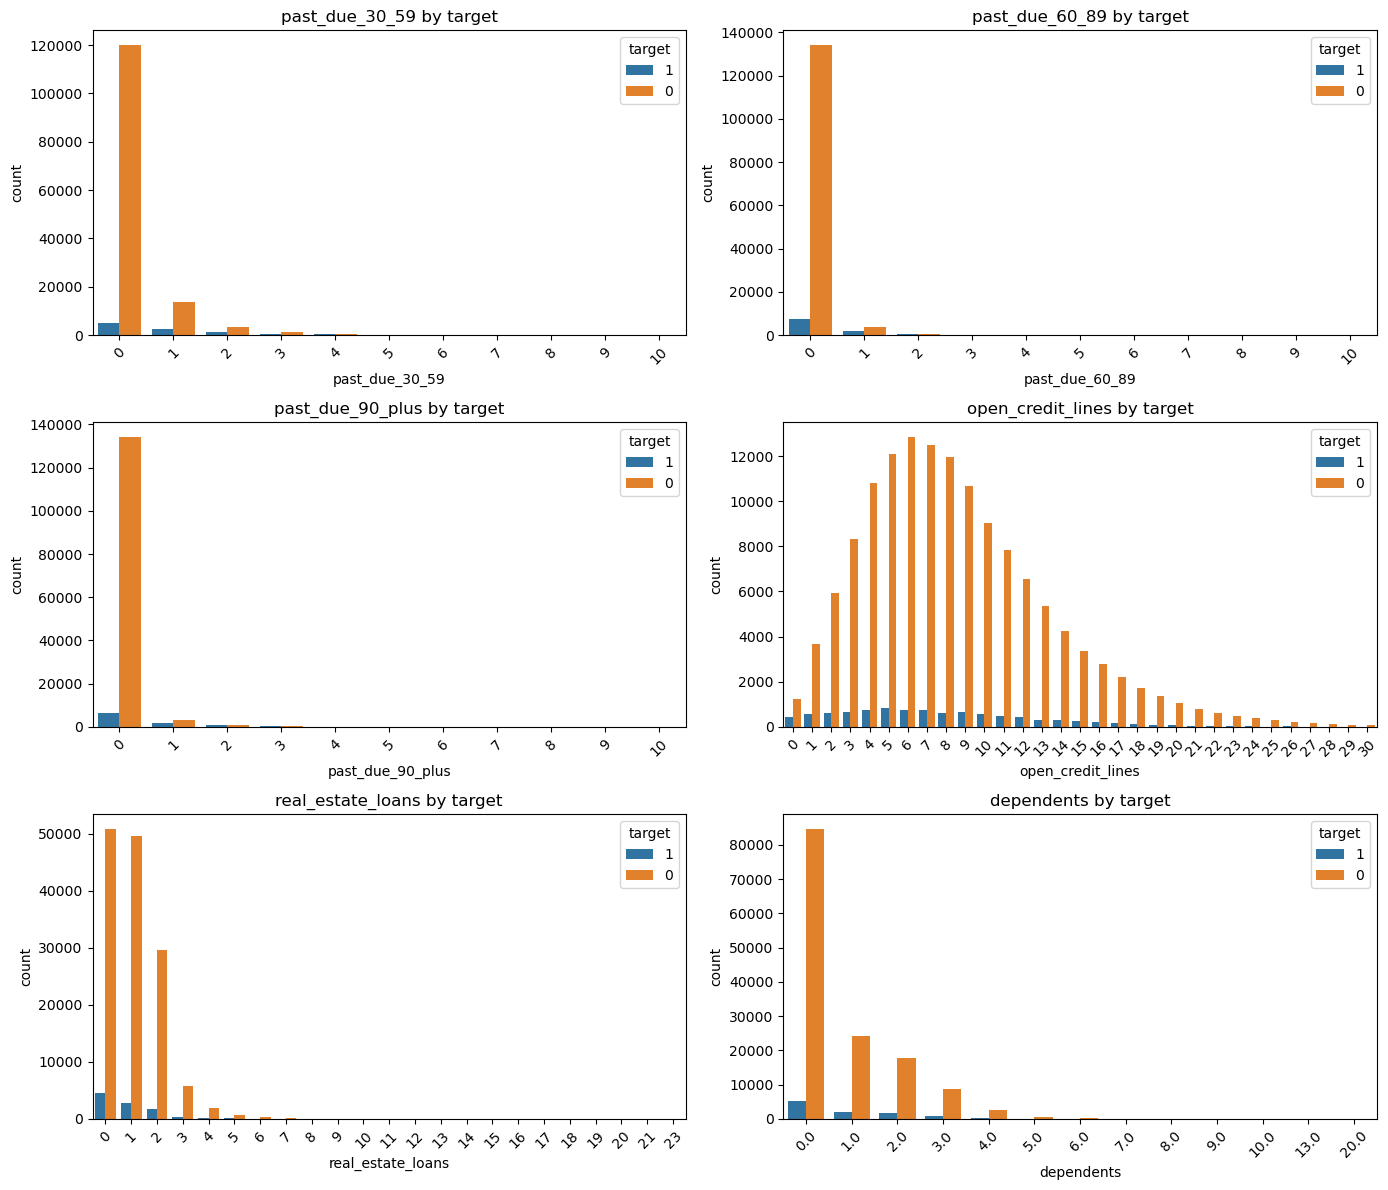

In [21]:
# Convert target to string for correct legend
data_eda['target'] = data_eda['target'].astype(str)

categorical = ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus',
               'open_credit_lines', 'real_estate_loans', 'dependents']

# Number of rows and columns of graphs
n_cols = 2
n_rows = (len(categorical) + 1) // n_cols

# Size of the whole figure
plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(categorical, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data_eda, x=col, hue='target')
    plt.title(f'{col} by target')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Returning data type integer
data_eda['target'] = data_eda['target'].astype(int)

Key observations:
- past_due_*: with delinquencies (>0), the share of defaulters increases sharply.
- open_credit_lines: defaults are more common with a small number of loans (1–5).
- real_estate_loans: defaults are more common with zero or one loan.
- dependents: weak relationship, but a small increase in defaults with 2+ dependents.

📌 Conclusion:
- past_due_* are strong predictors.
- open_credit_lines — can be useful in combination.
- real_estate_loans, dependents — weaker, can be simplified (binning or drop).

#### Correlations

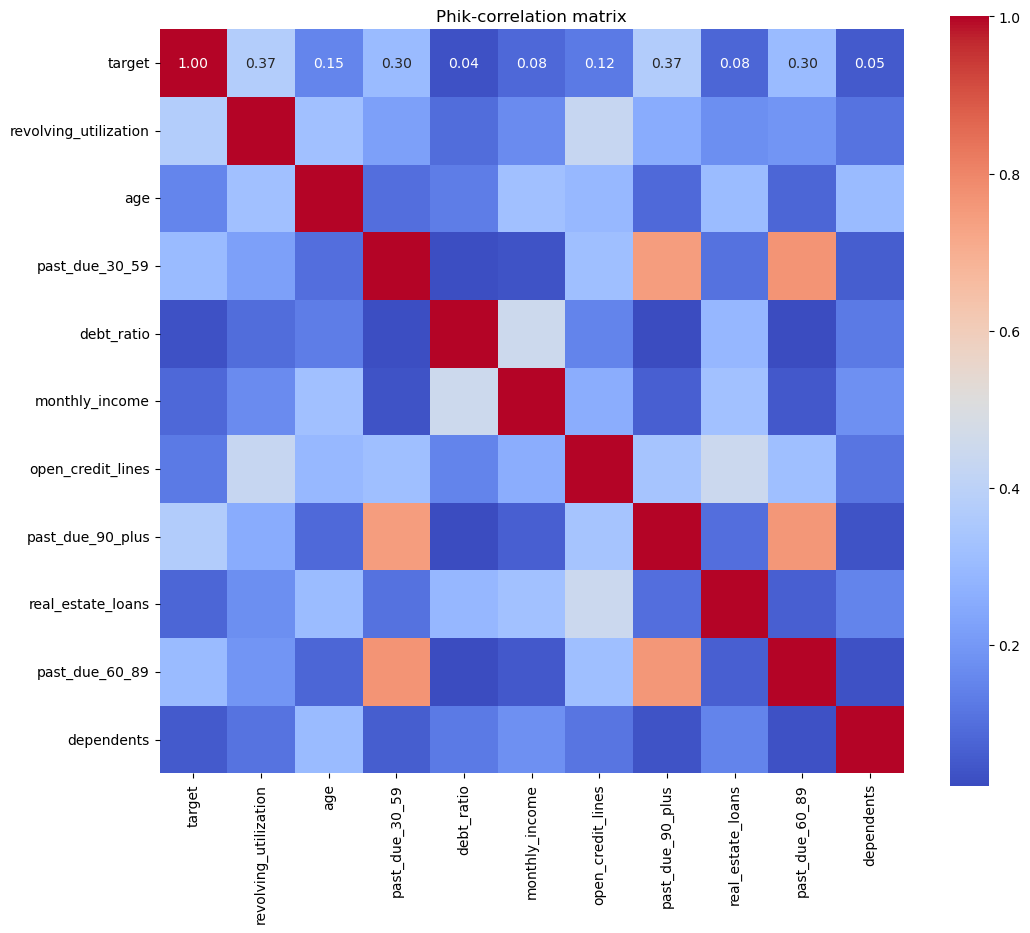

In [22]:
interval_cols = [
    'revolving_utilization',
    'age',
    'debt_ratio',
    'monthly_income'
]

# Calculation of the full correlation matrix
phik_corr = data_eda.phik_matrix(interval_cols=interval_cols)

# Heat-map
plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True)
plt.title("Phik-correlation matrix")
plt.show()

📌 **Conclusions:**

The most important features for target:
- revolving_utilization
- past_due_90_plus, past_due_30_59, past_due_60_89
- age (moderate)

Weak features (can be removed during model optimization):
- dependents, real_estate_loans, debt_ratio

There are highly correlated groups, especially among delinquencies - should be reduced or combined.
monthly_income is related to other features, but weakly to target - there may be a nonlinear dependence.

## Logistic regression model

Since the data is unbalanced: there are more good clients than bad ones, we use the ROC-AUC quality metric. This is a standard metric for binary classification problems with unbalanced classes, especially in the banking sector (risk management, scoring).
Additionally, we use a pipeline for pre-processing so that the model can preprocess on test data as well.

In [23]:
# clean_features function for pre-processing
def clean_features(X):
    X = X.copy()

    # age - cannot be less than 18
    X['age'] = X['age'].clip(lower=18)

    # limiting extreme values
    for col in ['revolving_utilization', 'debt_ratio', 'monthly_income']:
        upper = X[col].quantile(0.99)
        X[col] = X[col].clip(upper=upper)

    # open_credit_lines: max 30
    X['open_credit_lines'] = X['open_credit_lines'].clip(upper=30)

    # past_due: max 10
    for col in ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus']:
        X[col] = X[col].clip(upper=10)

    return X

In [24]:
# train-test split
X = data.drop(columns='target')
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

num_features = ['revolving_utilization', 'age', 'debt_ratio', 'monthly_income']
cat_features = ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus',
                'open_credit_lines', 'real_estate_loans', 'dependents']

In [25]:
# pre-processing
cleaner = FunctionTransformer(clean_features)

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = SimpleImputer(strategy="constant", fill_value=0)

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

pipeline = Pipeline(steps=[
    ("cleaning", cleaner),
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(max_iter=5000))
])

In [26]:
# GridSearchCV
param_grid = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["liblinear"],
    "classifier__class_weight": [None, "balanced"]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [27]:
# training the model
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best CV ROC-AUC: 0.8557


📌 The cross validated metric value of 0.8557 is quite good. This means that with a probability of 86% the model correctly distinguishes a client who will not repay the loan from one who will.

## Random forest classifier

In [28]:
# model parameters
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 3],
    'classifier__class_weight': [None, 'balanced']
}

In [29]:
# pipeline with RandomForest
pipeline_rf = Pipeline(steps=[
    ("cleaning", FunctionTransformer(clean_features)),
    ("preprocessing", preprocessor),
    ("classifier", rf_model)
])

# GridSearchCV
grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [30]:
# training the model
grid_rf.fit(X_train, y_train)
print("Best parameters:", grid_rf.best_params_)
print("CV ROC-AUC:", round(grid_rf.best_score_, 4))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
CV ROC-AUC: 0.8644


The Random Forest model shows strong discriminatory power with a validation ROC-AUC of 0.8644, indicating excellent ability to distinguish defaulters from non-defaulters. Using 300 trees and a moderate max depth of 10 allowed the model to generalize well without overfitting. The class_weight=None setting suggests that the model handled class imbalance effectively on its own.

## Light GBM

In [31]:
# model parameters
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)

param_grid_lgbm = {
    'classifier__n_estimators': [100, 300],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, -1],
    'classifier__class_weight': [None, 'balanced']
}


In [32]:
# pipeline with LightGBM
pipeline_lgbm = Pipeline(steps=[
    ("cleaning", FunctionTransformer(clean_features)),
    ("preprocessing", preprocessor),
    ("classifier", lgbm_model)
])

# GridSearchCV
grid_lgbm = GridSearchCV(
    pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [33]:
# training the model
grid_lgbm.fit(X_train, y_train)
print("Best parameters:", grid_lgbm.best_params_)
print("CV ROC-AUC:", round(grid_lgbm.best_score_, 4))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
CV ROC-AUC: 0.8655


The LightGBM model slightly outperformed Random Forest with a validation ROC-AUC of 0.8655. Despite using a shallower tree depth (max_depth=3), the model benefited from a more sophisticated boosting approach and proper handling of class imbalance via class_weight='balanced'. The learning rate of 0.05 allowed stable convergence over 300 boosting rounds.

## Testing and choosing the best model

In [34]:
# logistic regression
best_model = grid.best_estimator_
y_val_proba = best_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_proba)
print("Validation ROC-AUC:", round(val_auc, 4))

Validation ROC-AUC: 0.8554


In [35]:
# Random forest
best_rf = grid_rf.best_estimator_
y_val_proba = best_rf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_proba)
print("Validation ROC-AUC:", round(val_auc, 4))

Validation ROC-AUC: 0.8629


In [36]:
# LGBM
best_lgbm = grid_lgbm.best_estimator_
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_proba)
print("Validation ROC-AUC:", round(val_auc, 4))

Validation ROC-AUC: 0.8644


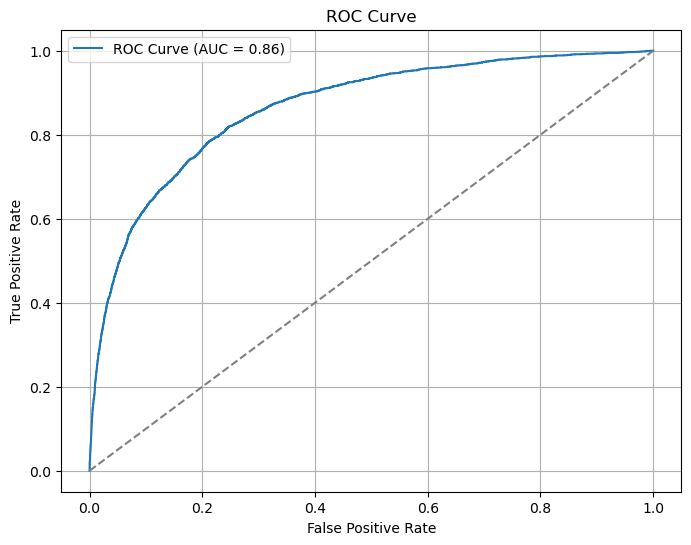

In [37]:
# --- ROC-curve ---
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

The best model on the training and validation data was LGBM. It showed the best metric with 0.8655 on the training set and 0.8644 on the test set. It also showed better performance compared to the random forest model, although it was slightly slower than logistic regression.

## Feature importance

In [38]:
# Extracting steps from a trained pipeline
cleaner = best_lgbm.named_steps['cleaning']
preprocessor = best_lgbm.named_steps['preprocessing']
lgbm_model = best_lgbm.named_steps['classifier']

In [39]:
# Applying preprocessing (cleaning + transformation)
X_val_cleaned = cleaner.transform(X_val)
X_val_processed = preprocessor.transform(X_val_cleaned)

In [40]:
# SHAP analysis
explainer = shap.Explainer(lgbm_model)
shap_values = explainer(X_val_processed)

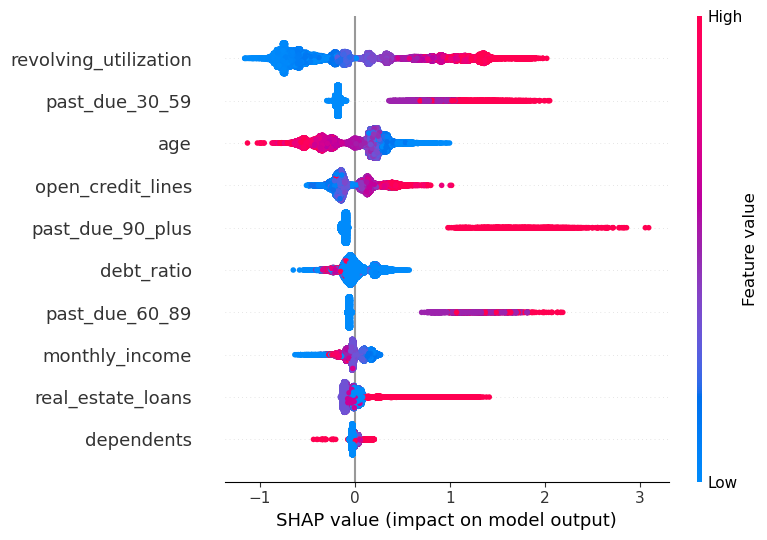

In [41]:
# SHAP summary plot
shap.summary_plot(shap_values, features=X_val_processed, feature_names=num_features + cat_features)

- revolving_utilization is the most important feature. High values → increase the risk of default.
- past_due_* features (30–59, 60–89, 90+) — also have a strong influence. Even a small value increases the risk.
- age: the younger the person, the higher the risk.
- monthly_income and open_credit_lines have a moderate influence.
- dependents, real_estate_loans — the least influence, you can consider excluding them during feature selection.

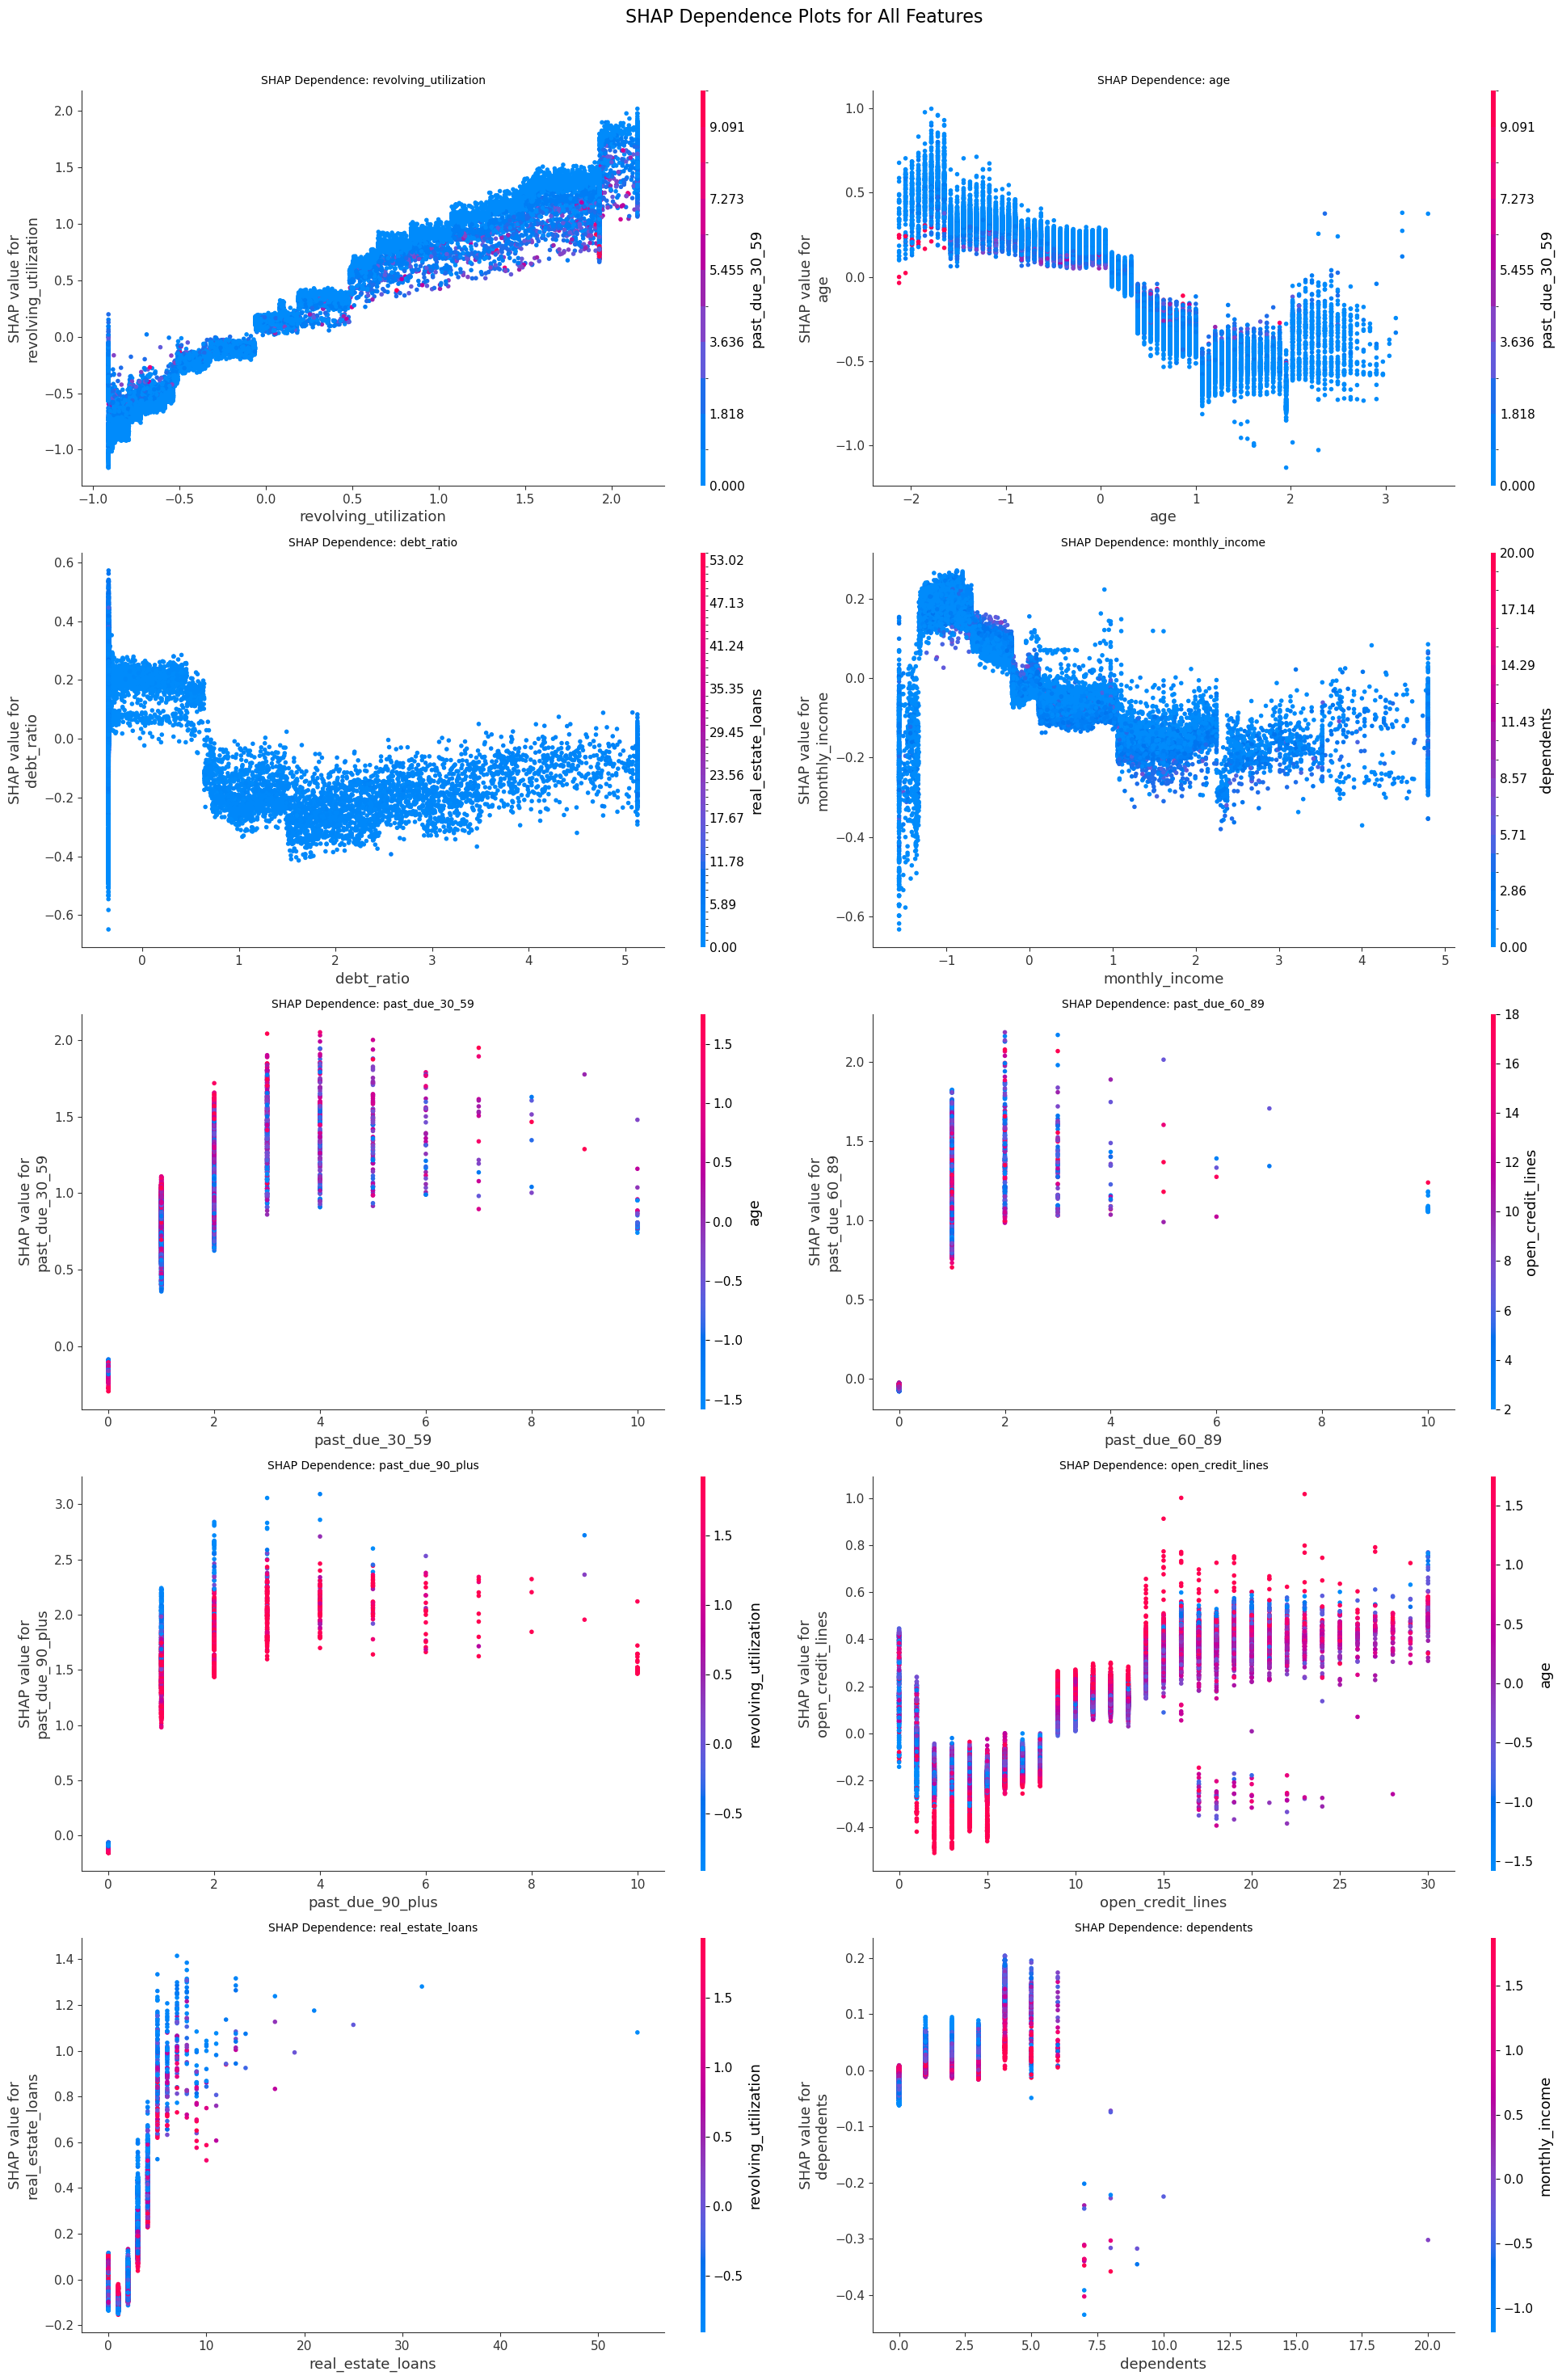

In [42]:
# SHAP dependence plot
# List of all features
all_features = num_features + cat_features

# Number of features
n_features = len(all_features)

# Grid and figure size
n_rows, n_cols = 5, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()

# SHAP dependence of each feature
for i, feature in enumerate(all_features):
    shap.dependence_plot(
        ind=feature,
        shap_values=shap_values.values,
        features=X_val_processed,
        feature_names=all_features,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f'SHAP Dependence: {feature}', fontsize=10)

# Removing empty subgraphs
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Heading и layout
plt.suptitle("SHAP Dependence Plots for All Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

🔑 Interpretation by features:
| Feature                            | What can be seen                                        | Conclusion                                            |
| ---------------------------------- | --------------------------------------------------------| ------------------------------------------------ |
| `revolving_utilization`            | at a value > 1 (100%) the risk increases sharply        | Credit overload is a major risk factor           |
| `past_due_90_plus`                 | even 1-2 delays give a big + contribution               | The most sensitive variable                      |
| `past_due_30_59`, `past_due_60_89` | similarly - step 0 → 1 - strong growth                  | Any delay is a risk indicator                    |
| `age`                              | SHAP contribution drops sharply after 30–35 years       | Young people are more risky, especially <25 y.o. |
| `debt_ratio`                       | the contribution is unstable, but grows at >2–3         | High debt burden comes with risk                 |
| `monthly_income`                   | the lower the income, the higher the SHAP contribution  | Income is a buffer against default               |
| `open_credit_lines`                | moderate influence, maximum at 5-10                     | Too little or too much is a risk                 |
| `real_estate_loans`, `dependents`  | almost flat graphs                                      | Low information content for the model            |


In [43]:
# SHAP force plot for first client
shap.initjs()

shap_value = shap_values[0]
shap_value.values = np.round(shap_value.values, 3)
shap_value.base_values = np.round(shap_value.base_values, 3)
shap_value.data = np.round(shap_value.data, 3)

shap.plots.force(shap_value)

- The model is very sensitive to overdue payments — even 1 case greatly increases the risk.
- Young age and high utilization are strong negative factors.
- Income and age are risk-reducing factors with adequate values.
- Some features (dependents, real_estate_loans) — have almost no effect → candidates for deletion.
- The model is not linear — many features have thresholds after which the contribution increases sharply.

## ECL

This project is based on the **open-source "Give Me Some Credit" dataset** from [Kaggle](https://www.kaggle.com/c/GiveMeSomeCredit), which contains historical financial and behavioral information about clients. However, the dataset does **not include all components required** to compute **Expected Credit Loss (ECL)** under the IFRS 9 framework.

To build a realistic ECL modeling pipeline, we extended the dataset with **engineered estimates** for the missing components — **LGD** and **EAD** — using available features and industry best practices.

We use the standard formula:

$$
\text{ECL} = \text{PD} \times \text{LGD} \times \text{EAD}
$$

Where:
- **PD** (*Probability of Default*) is predicted by a trained **LightGBM** model using cleaned and preprocessed client features;
- **LGD** (*Loss Given Default*) is assumed to be a **fixed value of 0.45**, reflecting a typical conservative benchmark when no recovery data is available;
- **EAD** (*Exposure at Default*) is approximated by:

$$
\text{EAD} = \text{debt\_ratio} \times \text{monthly\_income}
$$

This formulation reflects the idea that clients with higher income and higher relative debt burdens are likely to have higher credit exposure at default.

> These modeling decisions allow us to construct a realistic and interpretable ECL workflow, even in the absence of complete financial data. The result supports:
> - Client-level risk scoring,  
> - Credit loss estimation,  
> - Decision-making for provisioning and credit risk management.

In [44]:
X_train_df = X_train.copy()
display(X_train_df.head())

,revolving_utilization,age,past_due_30_59,debt_ratio,monthly_income,open_credit_lines,past_due_90_plus,real_estate_loans,past_due_60_89,dependents
9442,0.000000,75,0,43.000000,NaN,2,0,0,0,NaN
12387,0.000000,42,0,0.192241,7500.0,12,0,2,0,1.0
5440,1.000000,55,0,0.000000,2770.0,2,0,0,0,0.0
117216,0.373986,49,1,0.479231,11073.0,17,0,1,0,3.0
57274,0.028338,59,0,0.055978,2500.0,14,0,0,0,0.0


In [45]:
# Use only clean_features (emissions + clip)
X_train_cleaned = best_lgbm.named_steps['cleaning'].transform(X_train_df)

In [46]:
# Filling in gaps
X_train_cleaned = pd.DataFrame(X_train_cleaned, columns=X_train.columns)
X_train_cleaned['monthly_income'] = X_train_cleaned['monthly_income'].fillna(data['monthly_income'].median())
X_train_cleaned['dependents'] = X_train_cleaned['dependents'].fillna(0)

In [47]:
# Saving the processed features
X_train_df['monthly_income'] = X_train_cleaned['monthly_income']
X_train_df['debt_ratio'] = X_train_cleaned['debt_ratio']
display(X_train_df.head())

,revolving_utilization,age,past_due_30_59,debt_ratio,monthly_income,open_credit_lines,past_due_90_plus,real_estate_loans,past_due_60_89,dependents
9442,0.000000,75,0,43.000000,5400.0,2,0,0,0,NaN
12387,0.000000,42,0,0.192241,7500.0,12,0,2,0,1.0
5440,1.000000,55,0,0.000000,2770.0,2,0,0,0,0.0
117216,0.373986,49,1,0.479231,11073.0,17,0,1,0,3.0
57274,0.028338,59,0,0.055978,2500.0,14,0,0,0,0.0


In [48]:
# Calculation of PD
X_train_processed = best_lgbm.named_steps['preprocessing'].transform(X_train_cleaned)
X_train_df['pd'] = best_lgbm.named_steps['classifier'].predict_proba(X_train_processed)[:, 1]

In [49]:
# Calculation of LGD, EAD, ECL
X_train_df['lgd'] = 0.45
X_train_df['ead'] = X_train_df['debt_ratio'] * X_train_df['monthly_income']
X_train_df['ecl'] = X_train_df['pd'] * X_train_df['lgd'] * X_train_df['ead']
X_train_ecl = X_train_df[['pd', 'lgd', 'ead', 'ecl']].copy()
display(X_train_ecl.head())

,pd,lgd,ead,ecl
9442,0.075524,0.45,232200.000000,7891.504627
12387,0.173689,0.45,1441.807763,112.691844
5440,0.423647,0.45,0.000000,0.000000
117216,0.505256,0.45,5306.520766,1206.518059
57274,0.167375,0.45,139.944022,10.540403


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


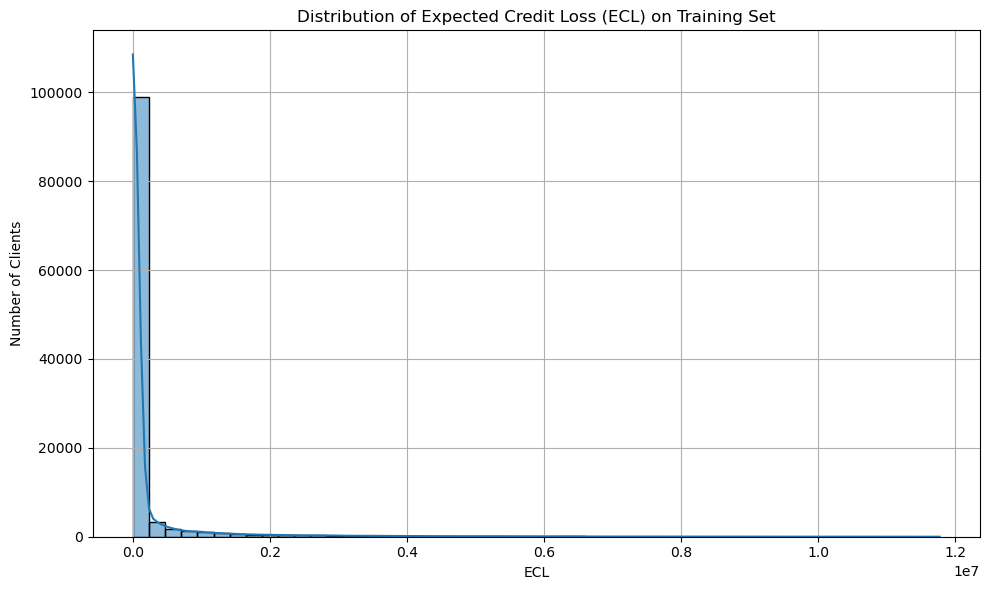

In [50]:
# Distribution of ECL
plt.figure(figsize=(10, 6))
sns.histplot(X_train_ecl['ecl'], bins=50, kde=True)
plt.title("Distribution of Expected Credit Loss (ECL) on Training Set")
plt.xlabel("ECL")
plt.ylabel("Number of Clients")
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Graph observations:
- Almost all clients have low ECL values, close to zero.
- Very long right tail — indicates a small number of clients with extreme risks.
- This distribution is typical for loan portfolios: the majority are low risk, a small share are “toxic” borrowers.

📌 Conclusion:
- The portfolio is highly asymmetric — the average and median ECL values will vary greatly.
- Client segmentation is required: low risk / medium / high risk.
- When calculating reserves or limits, it is worth considering that a few clients provide the lion's share of the risk.

In [51]:
# top 10 clients by ECL
top_ecl = X_train_ecl[['pd', 'lgd', 'ead', 'ecl']].sort_values(by='ecl', ascending=False).head(10)
print("Top 10 Clients by ECL:")
display(top_ecl)

Top 10 Clients by ECL:


,pd,lgd,ead,ecl
104001,0.971926,0.45,26922888.0,1.177517e+07
42104,0.970051,0.45,26922888.0,1.175245e+07
118409,0.960802,0.45,26922888.0,1.164040e+07
32986,0.958858,0.45,26922888.0,1.161686e+07
88447,0.975975,0.45,26411400.0,1.159959e+07
12867,0.957034,0.45,26922888.0,1.159475e+07
149764,0.956523,0.45,26922888.0,1.158856e+07
101424,0.945132,0.45,26922888.0,1.145056e+07
81879,0.943889,0.45,26922888.0,1.143549e+07
97370,0.972910,0.45,26049600.0,1.140476e+07


PD — Probability of Default
- All values are very high (from 0.943 to 0.976) — these are clients with a high probability of default.
- Such clients are at risk and require individual analysis/restrictions.

EAD — Exposure at Default
- Most clients have the same EAD score ≈ 26.9 million (exceptions are 97370 and 88447).
- This means that they have approximately the same combination of monthly_income × debt_ratio, even after processing or residual outliers are likely (or real large borrowers).

ECL — Expected Credit Loss
- The highest losses for each client are over 11 million units.
- This means that literally 10 clients can give hundreds of millions in losses if they default.io risk.

In [52]:
# Copy of the test_data
test_df = test_data.copy()

# Feature Processing: Cleaning and Immutation
test_cleaned = best_lgbm.named_steps['cleaning'].transform(test_df)
test_cleaned = pd.DataFrame(test_cleaned, columns=test_df.columns)

# Filling in the blanks
test_cleaned['monthly_income'] = test_cleaned['monthly_income'].fillna(data['monthly_income'].median())
test_cleaned['dependents'] = test_cleaned['dependents'].fillna(0)

# PD Prediction
test_processed = best_lgbm.named_steps['preprocessing'].transform(test_cleaned)
test_df['pd'] = best_lgbm.named_steps['classifier'].predict_proba(test_processed)[:, 1]

# Calculation of LGD, EAD, ECL
test_df['lgd'] = 0.45
test_df['ead'] = test_cleaned['debt_ratio'] * test_cleaned['monthly_income']
test_df['ecl'] = test_df['pd'] * test_df['lgd'] * test_df['ead']

# Final table
test_ecl = test_df[['pd', 'lgd', 'ead', 'ecl']].copy()
display(test_ecl.head())

,pd,lgd,ead,ecl
1,0.509854,0.45,1011.822487,232.147003
2,0.390906,0.45,4819.472759,847.782034
3,0.150424,0.45,3495.312354,236.599793
4,0.556592,0.45,2963.074038,742.150375
5,0.596164,0.45,76.980082,20.651746


In [53]:
# Saving to CSV
try:
    test_ecl.to_csv('ECL_results.csv', index=False)
    print("✅ Predictions are saved in ECL_results.csv")

except Exception as e:
    print("❌ Failed to save predictions:", str(e))

✅ Predictions are saved in ECL_results.csv


## ✅ Final Summary & Results

### 🔁 Workflow Summary

1. **Data Cleaning & EDA**:
    - Removed duplicate rows (646 total).
    - Fixed invalid values (e.g., `age < 18`).
    - Capped outliers for `debt_ratio`, `monthly_income`, `revolving_utilization`.
    - Replaced `past_due_* = 98` with upper cap of 10.
    - Imputed missing `monthly_income` with median; `dependents` with 0.

2. **Modeling**:
    - Created a full preprocessing pipeline (FunctionTransformer + ColumnTransformer + Classifier).
    - Trained 3 models using `GridSearchCV`:
        - **Logistic Regression** (ROC-AUC ≈ 0.8554)
        - **Random Forest** (ROC-AUC ≈ 0.8629)
        - ✅ **LightGBM (Best Model)**:  
          - **CV ROC-AUC**: 0.8655  
          - **Validation ROC-AUC**: 0.8644  

3. **Model Explainability**:
    - Used **SHAP** values for the best model.
    - Identified key risk drivers:
        - `revolving_utilization`, `past_due_*`, and `age` as most influential.
        - `real_estate_loans` and `dependents` had low contribution — possible feature removal.

4. **ECL Estimation**:
    - Since the original dataset lacked LGD and EAD:
        - Used **fixed LGD = 0.45**
        - Engineered **EAD ≈ debt_ratio × monthly_income**
    - Calculated ECL for both **train** and **test** datasets.

5. **Risk Profiling**:
    - Plotted ECL distribution — highly right-skewed.
    - Identified **top 10 clients with highest ECL**.
    - Exported full `test_ecl` table as `ECL_results.csv`.

### 📊 Final Thoughts

- Our LightGBM model achieved strong predictive performance (AUC ≈ 0.864).
- Despite limitations of open-source data, we constructed a simplified but interpretable **ECL framework**.
- The pipeline is ready for deployment and scalable to real-world credit risk assessment.

> ✅ Project demonstrates how ECL modeling can be prototyped using public datasets and well-designed assumptions.
